In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
from array import array
import numpy as np
import cv2
import sift

In [ ]:
import camera

points = np.loadtxt("/home/jaxa/toshiki/sfmtutorial/3D/house.p3d").T
print(points.shape)
tmp = np.ones((1, points.shape[1]))
print(tmp.shape)
points = np.vstack((points, np.ones((1, points.shape[1]))))
print(points.shape)

P = np.hstack((np.eye(3), np.array([[0], [0], [-10]])))
cam = camera.Camera(P)
x = cam.project(points)

plt.figure()
plt.plot(x[0], x[1], "k.")
plt.show()

In [ ]:
r = 0.05*np.random.rand(3)
rot = camera.rotation_matrix(r)

plt.figure()
for i in range(20):
    cam.P = np.dot(cam.P, rot)
    x = cam.project(points)
    plt.plot(x[0], x[1], "k.")
plt.show()

In [ ]:
import camera

K = np.array([[1000,0,500],[0,1000,300],[0,0,1]])

tmp = camera.rotation_matrix([0,0,1])[:3,:3]
Rt = np.hstack((tmp,np.array([[50],[40],[30]])))
cam = camera.Camera(np.dot(K,Rt))

print(K, Rt)
print(cam.factor())

In [10]:
import camera

im1 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/images/001.jpg"))
im2 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/images/002.jpg"))

points2D = [np.loadtxt("2D/00"+str(i+1)+".corners").T for i in range(3)]

points3D = np.loadtxt("3D/p3d").T

corr = np.genfromtxt("2D/nview-corners", dtype="int", missing_values="*")

P = [camera.Camera(np.loadtxt("2D/00"+str(i+1)+".P")) for i in range(3)]

In [ ]:
X = np.vstack((points3D, np.ones(points3D.shape[1])))
x = P[0].project(X)

plt.figure()
plt.imshow(im1)
plt.plot(points2D[0][0], points2D[0][1], "*")
plt.axis("off")

plt.figure()
plt.imshow(im1)
plt.plot(x[0], x[1], "r.")
plt.axis("off")

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

X, Y, Z = axes3d.get_test_data(0.25)

ax.plot(X.flatten(), Y.flatten(), Z.flatten(), "o")

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(points3D[0], points3D[1], points3D[2], "k.")

In [ ]:
import sfm

ndx = (corr[:,0]>=0) & (corr[:,1]>=0)

x1 = points2D[0][:,corr[ndx,0]]
x1 = np.vstack((x1, np.ones(x1.shape[1])))
x2 = points2D[1][:, corr[ndx,1]]
x2 = np.vstack((x2, np.ones(x2.shape[1])))

F = sfm.compute_fundamental(x1, x2)
e = sfm.compute_epipole(F)

plt.figure()
plt.imshow(im1)

for i in range(5):
    sfm.plot_epipolar_line(im1, F, x2[:, i], e, False)
plt.axis("off")

plt.figure()
plt.imshow(im2)

for i in range(5):
    plt.plot(x2[0, i], x2[1, i], "o")
plt.axis("off")

plt.show()

In [ ]:
import sfm

ndx = (corr[:,0]>=0) & (corr[:,1]>=0)

x1 = points2D[0][:,corr[ndx,0]]
x1 = np.vstack((x1, np.ones(x1.shape[1])))
x2 = points2D[1][:, corr[ndx,1]]
x2 = np.vstack((x2, np.ones(x2.shape[1])))

Xtrue = points3D[:, ndx]
Xtrue = np.vstack((Xtrue, np.ones(Xtrue.shape[1])))

Xest = sfm.triangulate(x1, x2, P[0].P, P[1].P)
print(Xest[:,:3])
print(Xtrue[:,:3])

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot(Xest[0], Xest[1], Xest[2], "ko")
ax.plot(Xtrue[0], Xtrue[1], Xtrue[2], "r.")

plt.axis("equal")
plt.show()

In [ ]:
import sfm, camera

corr_tmp = corr[:,0] # 第1視点
ndx3D = np.where(corr_tmp>=0)[0] # 欠けた値は-1
ndx2D = corr_tmp[ndx3D]

x = points2D[0][:,ndx2D]
x = np.vstack((x, np.ones(x.shape[1])))
X = points3D[:,ndx3D]
X = np.vstack((X, np.ones(X.shape[1])))

Pest = camera.Camera(sfm.compute_P(x, X))

print(Pest.P / Pest.P[2,3])
print(P[0].P / P[0].P[2,3])

xest = Pest.project(X)

plt.figure()
plt.imshow(im1)
plt.plot(x[0],x[1], "bo")
plt.plot(xest[0],xest[1], "r.")
plt.axis("off")
plt.show()

In [ ]:
import homography
import sfm
import sift

im1 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000000.jpg"))
im2 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000007.jpg"))

l1, d1 = sift.read_features_from_file("/home/jaxa/toshiki/sfmtutorial/sift_mini/00000000.sift")
l2, d2 = sift.read_features_from_file("/home/jaxa/toshiki/sfmtutorial/sift_mini/00000012.sift")

matches = sift.match_twosided(d1, d2)
ndx = matches.nonzero()[0]

x1 = homography.make_homog(l1[ndx,:2].T)
ndx2 = [int(matches[i]) for i in ndx]
x2 = homography.make_homog(l2[ndx2,:2].T)

model = sfm.RansacModel()
F, inliners = sfm.F_from_ransac(x1, x2, model)

P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = sfm.compute_P_from_fundamental(F)

In [ ]:
import homography
import sfm
import sift

im1 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000000.jpg"))
im2 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000012.jpg"))

l1, d1 = sift.read_features_from_file("/home/jaxa/toshiki/sfmtutorial/sift_mini/00000000.sift")
l2, d2 = sift.read_features_from_file("/home/jaxa/toshiki/sfmtutorial/sift_mini/00000012.sift")

matches = sift.match_twosided(d1, d2)
ndx = matches.nonzero()[0]
ndx2 = [int(matches[i]) for i in ndx]

p1 = l1[ndx,:2]
p2 = l2[ndx2,:2]

F, inliners = cv2.findFundamentalMat(p1, p2, cv2.FM_RANSAC, ransacReprojThreshold=1, confidence=0.99)

print(F)

P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = sfm.compute_P_from_fundamental(F)

print(P1)
print(P2)

In [ ]:
print(inliners)

In [ ]:
im1 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000000.jpg"))
im2 = np.array(Image.open("/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000012.jpg"))

x1 = homography.make_homog(l1[ndx,:2].T)
x2 = homography.make_homog(l2[ndx2,:2].T)

print(l1)
print(l1.shape)
print(x1.shape)

X = sfm.triangulate(x1[:, inliners].squeeze(axis=-1), x2[:, inliners].squeeze(axis=-1), P1, P2)

print(X)
print(X.shape)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(-X[0], X[1], X[2], "k.")
plt.axis("off")

2055


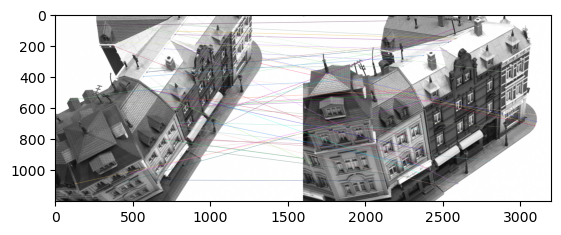

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread('/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000000.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/home/jaxa/toshiki/sfmtutorial/scan9_mini/00000012.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

matches = sorted(matches, key=lambda x: x.distance)

print(len(matches))

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)
plt.show()

In [3]:
query_idxs = [matches[i].queryIdx for i in range(len(matches))]
print(query_idxs)
p1 = np.array([keypoints1[i].pt for i in query_idxs])
print(p1.shape)
train_idxs = [matches[i].queryIdx for i in range(len(matches))]
print(train_idxs)
p2 = np.array([keypoints2[i].pt for i in train_idxs])
print(p2.shape)


[4633, 3250, 4634, 6998, 3476, 4143, 6071, 266, 4976, 4183, 4755, 5861, 4496, 4509, 4760, 6974, 7007, 3249, 3750, 1892, 4923, 1018, 4188, 7005, 4817, 1460, 1226, 3247, 280, 3005, 3559, 4200, 4893, 4780, 3436, 2032, 177, 5698, 4859, 526, 3406, 4228, 5350, 3699, 3006, 4984, 3600, 4491, 6147, 5702, 182, 4840, 2442, 4402, 543, 3655, 4478, 198, 772, 6641, 3178, 5664, 3546, 410, 4141, 6021, 3576, 2441, 5284, 4576, 4947, 4732, 4239, 2001, 4487, 4169, 4016, 4011, 3762, 3278, 247, 6858, 78, 751, 1480, 279, 4870, 4970, 4508, 2435, 6090, 6034, 6052, 5950, 2286, 3193, 6462, 4894, 2500, 2951, 4583, 3354, 6434, 4157, 1157, 4539, 5857, 4759, 4902, 5161, 3693, 2086, 1141, 3251, 6705, 6744, 1916, 2085, 504, 1818, 154, 6087, 2287, 4802, 4987, 643, 2118, 1240, 422, 4765, 1357, 861, 1839, 808, 1510, 732, 1794, 4790, 5665, 2175, 3757, 6625, 6619, 4866, 3992, 5277, 4136, 4986, 2176, 6969, 1917, 1838, 2013, 1025, 3257, 5339, 64, 4332, 6857, 3735, 694, 610, 6759, 3916, 4287, 4831, 693, 5283, 4673, 4503, 2119,

In [5]:
import sfm

F, inliners = cv2.findFundamentalMat(p1, p2, cv2.FM_RANSAC, ransacReprojThreshold=1, confidence=0.99)

print(F)
print(np.sum(inliners == 1))

P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = sfm.compute_P_from_fundamental(F)

print(P1)
print(P2)

[[ 3.40798116e-06 -8.80984621e-08 -1.24835372e-03]
 [ 2.62649450e-08  1.01175560e-10 -1.60516157e-05]
 [-2.40633566e-03  4.78231157e-05  1.00000000e+00]]
203
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
[[-2.30138489e+01 -2.95917298e-01  1.84353590e+04  5.64008976e+02]
 [ 7.04086110e-01  9.05328160e-03 -5.64011383e+02  1.84353590e+04]
 [-6.28770445e-02 -4.84146628e-04  4.43886344e+01  1.00000000e+00]]


In [7]:
import homography

x1 = homography.make_homog(p1.T)
print(x1.shape)
print(x1)
x2 = homography.make_homog(p2.T)

(3, 2055)
[[7.74372437e+02 5.91951294e+02 7.74372437e+02 ... 9.36822083e+02
  6.82888245e+02 1.11875793e+03]
 [1.25718246e+02 3.68017883e+02 1.25718246e+02 ... 5.31899841e+02
  7.13834656e+02 3.75055450e+02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


[[5.23351535e+03 3.61620068e+04 5.23351535e+03 ... 5.23351535e+03
  5.23351535e+03 5.23351535e+03]
 [8.49654281e+02 2.24820374e+04 8.49654281e+02 ... 8.49654281e+02
  8.49654281e+02 8.49654281e+02]
 [9.00281761e+00 6.94522747e+01 9.00281761e+00 ... 9.00281761e+00
  9.00281761e+00 9.00281761e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
(4, 2055)


(-38417.20929724808,
 -2978.3128467677643,
 -727.7069905309322,
 24059.39869797787,
 7.743453918089191,
 70.71163839712688)

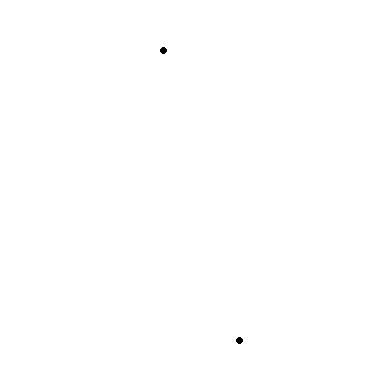

In [8]:
X = sfm.triangulate(x1[:, inliners].squeeze(axis=-1), x2[:, inliners].squeeze(axis=-1), P1, P2)

print(X)
print(X.shape)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(-X[0], X[1], X[2], "k.")
plt.axis("off")